## Decision Trees (for Classification)

In a decision tree the data is split at each node according to a decision rule. This corresponds to nested _if-then-else_-rules. In the _if_-part of such a rule are decison is made based on a feature of the data record. 

We will use the scikit learn implementation. For this implementation the features must be binary or have (at least) ordinal characteristic. If a feature is e.g. nominal with many values, it must be converted to a set of binary (one-hot-coded) features.


The splitting rules in the scikit learn implementation are binary and are based on a threshold, e.g.
  - _if $x_6 <= 2.14$ then_ left subbranch, _else_ right subbranch.         
  - binary features must be coded as 0/1, so the rule becomes: if $x_2 <= 0.5$ _then_ left subbranch, _else_ right subbranch. 


<!--The structure of the tree will be determined by data (see below) and a training procedure.-->

In the leafs of the tree the (class) predictions are made. There are two possibilities for such an inference: 
   - hard assignment: Predict for the data records which end up on a leaf by the majority class of the training data that end up on that leaf.          
   - soft assignment: Assign probabilities according to the distribution of the classes in respect to the training data which end up on that leaf.

As an example of a decision tree we will learn the following tree from the titanic data set: 
<img src="./data/titanic.png" width="1000px"/>

A full explanation of the tree will be given later. Here just look at the desion rules (first line of the inner nodes) and at the last line of the leafs. In each leaf you see a array with counts of the different targets (train data): [number_died number_survivors] .

### Learning 

Finding a tree that splits the traing data optimal is np-hard. Therefore often a _greedy_-strategy is used:

To build up a decision tree the algorithm starts at the root of the tree. The feature and the threshold 
that splits the training data best (with respect to the classes) are choosen. In an iterative way the whole tree is build up by such splitting rules. 

There are different criteria for measuring the "separation (split) quality". The most important ones are:

- Gini Impurity 
- Information Gain 

In this tutorial we use the information gain.

#### Information Gain as splitting criterion

The entropy with respect to the target class variable $y$ of a training data set $\mathcal D$ is defined as:

$$
 H(y, \mathcal D) = - \sum_{y \in \mathcal Y} p(y|\mathcal D) \log_2 p(y|\mathcal D)
$$
with the domain of the target values $\mathcal Y = \{t_1, t_2,... \}$.


The probabilities are estimated by 
$$
  p(y=t_i, \mathcal D) = |\mathcal D^{(y=t_i)}| /|\mathcal D| 
$$    


with the number of training data $|\mathcal D|$  and the number of training data $|\mathcal D^{(y=t_i)}|$ with target label $t_i$: 


On a node a (binary) split on a feature $x_k$ is made by the split rule $x_k \leq v$. 
As result there are two data sets $\mathcal D_0$ and $\mathcal D_1$ for the left resp. the right branch.

The feature $x_k$ and the split value $v$ are choosen that they maximize the 'reduction of the entropy' measured by the information gain $I$:
$$
  I(y; x_k) = H(y, \mathcal D) - H(y|x_k) = H(y, \mathcal D) - \sum_{j=0}^1 p_jH(y, \mathcal D_j) =
  H(y, \mathcal D) + \sum_{j=0}^1  \sum_{y \in \mathcal Y} \frac{|\mathcal D_j|}{|\mathcal D|} p(y|\mathcal D_j) \log_2 p(y|\mathcal D_j)
$$
Note that $p_{j=0}$  is the estimated probability that a random data record of $\mathcal D$ has feature value $x_k \leq v$ which can be estimated by ${|\mathcal D_0|}/{|\mathcal D|}$ (analog for $j=1$).

$p(y=t_i|\mathcal D_0)$ can also be estimated by the fraction of the counts ${|\mathcal D_0^{(y=t_i)}|}/{|\mathcal D_0|}$. 
So the information gain can be computed just with counts:


$$
  I(y; x_k) = 
   \sum_{y \in \mathcal Y} \frac{|\mathcal D^{(y=t_i)}|}{|\mathcal D|}  \log_2 \frac{|\mathcal D^{(y=t_i)}|}{|\mathcal D|} + \sum_{j=0}^1  \sum_{y \in \mathcal Y} \frac{|\mathcal D_j^{(y=t_i)}|}{|\mathcal D|}  \log_2 \frac{|\mathcal D_j^{(y=t_i)}|}{|\mathcal D_j|}
$$


<!--$|\mathcal D_0|$ respectivly $|\mathcal D_1|$ is the number of elements in the splitted data sets.-->
 

#### Overfitting

Deep decision trees generalize often poorly. The following remedies reduce overfitting: 

- Limitation of the maximal depth of the tree. 
- Pruning with an validation set either during training (pre-pruning) or after training (post-pruning).
- Dimensionality reduction (reducing the number of features before training)


Also often combining decision trees to an ensemble (decision forests) is used against overfitting.  

### Example: Survival of the Titanic 


First you have read in the titanic data with pandas:

In [2]:
import pandas as pd
import numpy as np
train_df = df = pd.read_csv('/Users/marvinkruger/wissensrepr/dec_tree/train.csv') # Exercise

`train_df` is a [_pandas_](http://pandas.pydata.org/) [data frame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html). 
Let's view the data. 

In [3]:
print(train_df)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25         0       3   
25          

Scikit's learn decision trees can handle only numeric data. So we must convert the nominal `Sex` feature. 

In [4]:
train_df["Sex"] = df.Sex.astype("category").cat.codes

`Survived` is the target, that we want to predict from the values of the other columns.   
But not all of the other columns are helpful for classification. So we choose a feature set by hand and convert the features into a numpy array for scikit learn. 

In [5]:
y = targets = df["Survived"]# =  TODO as Exercise
columns = ["Fare", "Pclass", "Sex", "Age", "SibSp"]
features = df[columns] #TODO as Exercise

There are missing values (`nan`). We use the scikit learn `Imputer` to replace them by the mean of the columns.

In [6]:
from sklearn.preprocessing import Imputer
imp=Imputer(missing_values="NaN", strategy="mean", axis=1)
filled_df = pd.DataFrame(imp.fit_transform(features))
filled_df.columns = features.columns
filled_df.index = features.index
features = filled_df
features = np.array(features)
print(features)

[[  7.25     3.       1.      22.       1.    ]
 [ 71.2833   1.       0.      38.       1.    ]
 [  7.925    3.       0.      26.       0.    ]
 ..., 
 [ 23.45     3.       0.       6.8625   1.    ]
 [ 30.       1.       1.      26.       0.    ]
 [  7.75     3.       1.      32.       0.    ]]


Now we are ready to learn a decision tree by the criterion 'Information Gain' and we restrict the depth of the tree to 3.
We use the [scikit learn decison tree module](http://scikit-learn.org/stable/modules/tree.html).

We use a splitting criterion the 'Information Gain'!

In [8]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion="entropy",max_depth=3) # TODO as Exercise
clf = clf.fit(features, y)

`clf` is an instance of a trained decision tree classifier.

The decision tree can be visualized. For this we must write an graphviz dot-File  

In [20]:
from sklearn.externals.six import StringIO
with open("/Users/marvinkruger/wissensrepr/dec_tree/data/titanic.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f, feature_names=columns)

The dot file can be converted with the graphiz `dot`- renderer to an image.

    dot -Tpng titanic.dot -o titanic.png

Here is the graph:


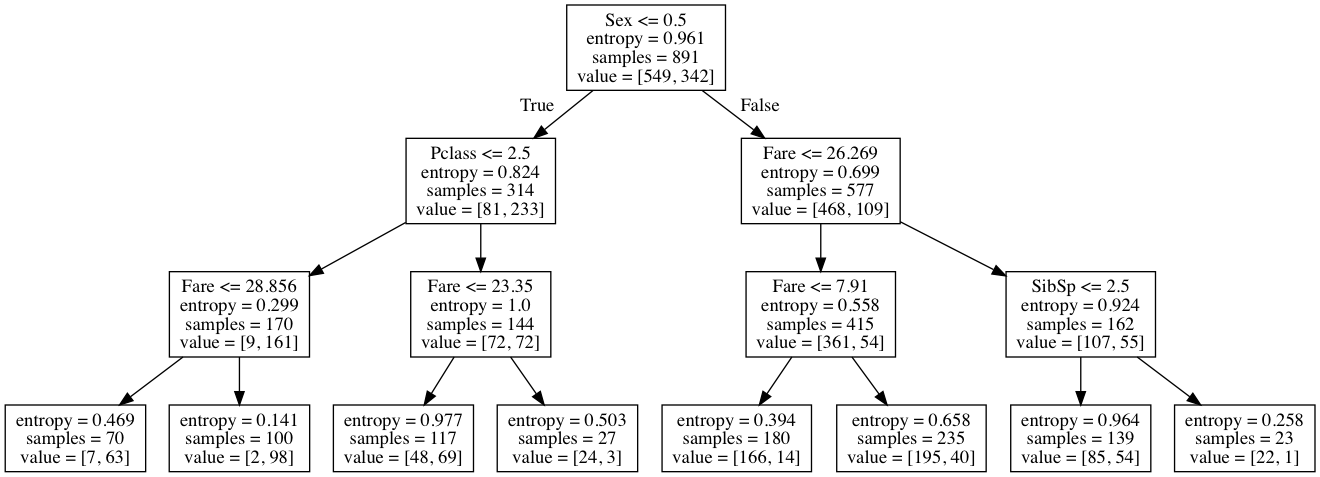

In [21]:
from IPython.display import Image
Image(filename='/Users/marvinkruger/wissensrepr/dec_tree/data/titanic.png')

<img src="./data/titanic.png" width="1000px"/>


According to the decision tree the main criterion (root node) for survival is the sex of the passenger. In the left subtree are the male passengers (sex = 0), in the right subtree the female (sex=1). 

In the leafs the class information is given by a `value` array. Here the second value is the number of survivers in the leafs.

For example the leftmost leaf represents passengers that are male (sex=0) with fare<=26.2687 and age<=13.5. 13 of such boys survived and 2 of them died.

The entropy $- \sum p_i \log_2 (p_i)$ is displayed also at each node (splitting criterion).


### Exercises: Splitting criterion entropy / information gain

#### Exercise 1: 

Compute the root node entropy (with numpy).

In [33]:
nr_of_survivors = np.count_nonzero(np.array(y) == 1)
nr_of_deaths = np.count_nonzero(np.array(y) == 0)
props = np.array([nr_of_survivors/len(y), nr_of_deaths/len(y)])
entropy = - np.sum(props * np.log2(props))
print("Entropy: ", entropy)

Entropy:  0.960707901876


#### Exercise 2

Compute the information gain of the first split node (root node). Use the entropy values and the number of data records (samples)
from the decision tree image. 




In [36]:
entropy_root = 0.961
entropy_split_true = 0.824
entropy_split_false = 0.699
information_gain = entropy_root - ((549/len(y) * entropy_split_true) + (342/len(y) * entropy_split_false))
print("Information gain: ", information_gain)

0.18497979797979802


#### Exercise 3
Compute the information gain of the following split table:

|  | class 0  | class 1  |  
|---|---|---|
| feature <= v| 2  | 13  |      
| feature > v | 359  |  41 |   

The numbers are the corresponding data records, e.g. there are 13 data records with target class 1 and feature <= v. 

Write a python function that computes the information gain.The data is given by a python array:

In [42]:
data = np.array([[2.,13.],[359., 41.]])

def get_entropy(props):
    return - np.sum(props * np.log2(props))

def compute_information_gain(data):
    entire_data_amount = sum(data[0]) + sum(data[1])
    props_root = np.array([sum(data[0])/entire_data_amount, sum(data[1])/entire_data_amount])
    entropy_root = get_entropy(props_root)
    
    entire_data_amount_split_1 = sum(data[0])
    props_split_1 = np.array([data[0][0]/entire_data_amount_split_1, data[0][1]/entire_data_amount_split_1])
    entropy_split_1 = get_entropy(props_split_1)

    entire_data_amount_split_2 = sum(data[1])
    props_split_2 = np.array([data[1][0]/entire_data_amount_split_2, data[1][1]/entire_data_amount_split_2])
    entropy_split_2 = get_entropy(props_split_2)
    
    return entropy_root - ((sum(data[0])/entire_data_amount * entropy_split_1) + (sum(data[1])/entire_data_amount * entropy_split_2))


print(compute_information_gain(data))

-0.255783676224


### Prediction

To make predictions with scikit learn, we must convert the data in
the same way as we did it with the training data. Then we could use the method:    

    clf.predict(testdata)
    
Note: The depth of the decision tree is a hyperparameter. So the depth should be determined with the help of a 
validation set or by cross validation.    

### Literature

- [Cri] [A. Criminisi, J. Shotton, and E. Konukoglu, Decision Forests for Classification, Regression, Density Estimation, Manifold Learning and Semi- Supervised Learning, no. MSR-TR-2011-114, 28 October 2011.](http://research.microsoft.com/pubs/155552/decisionForests_MSR_TR_2011_114.pdf)
